In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV


In [4]:
# Load the dataset
df = pd.read_csv("data/oversampled_movies_2015_2023_genres.csv")
df.head()

,title,release_year,language,genre,overview,vote_average,vote_count,popularity,cleaned_overview
0,Limbo,2020,Amerikanisch,Humor,offbeat observation refugee waiting granted as...,6.881,105.0,6.726,offbeat observation refugee waiting granted as...
1,"Fear, Inc.",2016,Amerikanisch,Horror,horror junkie joe foster get live ultimate sca...,5.655,187.0,11.771,horror junkie joe foster get live ultimate sca...
2,Dear David,2023,Amerikanisch,Horror,shortly comic artist adam responds internet tr...,4.588,57.0,14.591,shortly comic artist adam responds internet tr...
3,The 5th Wave,2016,Amerikanisch,Action,16yearold cassie sullivan try survive world de...,5.943,5692.0,26.711,yearold cassie sullivan try survive world deva...
4,The Scientist,2020,Amerikanisch,Horror,unconventional scientist struggling care termi...,6.046,108.0,8.472,unconventional scientist struggling care termi...


In [5]:
# Check for missing values and remove them
df_cleaned = df.dropna(subset=['cleaned_overview', 'language', 'genre'])
df_cleaned.head()

,title,release_year,language,genre,overview,vote_average,vote_count,popularity,cleaned_overview
0,Limbo,2020,Amerikanisch,Humor,offbeat observation refugee waiting granted as...,6.881,105.0,6.726,offbeat observation refugee waiting granted as...
1,"Fear, Inc.",2016,Amerikanisch,Horror,horror junkie joe foster get live ultimate sca...,5.655,187.0,11.771,horror junkie joe foster get live ultimate sca...
2,Dear David,2023,Amerikanisch,Horror,shortly comic artist adam responds internet tr...,4.588,57.0,14.591,shortly comic artist adam responds internet tr...
3,The 5th Wave,2016,Amerikanisch,Action,16yearold cassie sullivan try survive world de...,5.943,5692.0,26.711,yearold cassie sullivan try survive world deva...
4,The Scientist,2020,Amerikanisch,Horror,unconventional scientist struggling care termi...,6.046,108.0,8.472,unconventional scientist struggling care termi...


In [6]:
# Combine the 'cleaned_overview' and 'genre' columns 
df_cleaned.loc[:, 'combined_text'] = df_cleaned['cleaned_overview'] + ' ' + df_cleaned['genre']

In [7]:
# Define features (X) and target (y)
X = df_cleaned['combined_text']
y = df_cleaned['language']

In [8]:
# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Extraction Using TF-IDF

In [9]:
# Handle missing values by replacing NaN with an empty string
X_train = X_train.fillna('')
X_test = X_test.fillna('')


In [10]:
# Use TF-IDF Vectorizer to extract features
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=30000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [11]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode the 'language' column
y_encoded = label_encoder.fit_transform(df['language'])

# Print the mapping of languages to numerical labels
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

{'Amerikanisch': np.int64(0), 'Deutsch': np.int64(1), 'Französisch': np.int64(2), 'Indisch': np.int64(3), 'Italienisch': np.int64(4), 'Spanisch': np.int64(5)}


## Implementing KNN Classifier

In [12]:
# Initialize the KNN classifier with default parameters
knn = KNeighborsClassifier(n_neighbors=5, metric='cosine', weights='distance')

# Train the KNN model
knn.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = knn.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Initial Test Accuracy: {accuracy:.3f}')
print(classification_report(y_test, y_pred))


Initial Test Accuracy: 0.884
              precision    recall  f1-score   support

Amerikanisch       0.90      0.77      0.83       907
     Deutsch       0.89      0.93      0.91       912
 Französisch       0.88      0.88      0.88       915
     Indisch       0.90      0.95      0.92       851
 Italienisch       0.88      0.96      0.92       877
    Spanisch       0.86      0.83      0.84       914

    accuracy                           0.88      5376
   macro avg       0.88      0.88      0.88      5376
weighted avg       0.88      0.88      0.88      5376



## Hyperparameter Tuning with Grid Search

In [13]:
# Define the parameter grid for tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],  # Try different neighbor counts
    'weights': ['uniform', 'distance'],  # Uniform or distance-weighted
    'metric': ['cosine']  # We stick with cosine similarity
}

In [14]:
# Use GridSearchCV to find the best hyperparameters
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_knn.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/codespace/.local/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['cosine'],
                         'n_neighbors': [3, 5, 7, 9, 11, 15],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [15]:
# Output the best parameters and the best score
print(f'Best parameters: {grid_search_knn.best_params_}')
print(f'Best cross-validation accuracy: {grid_search_knn.best_score_:.3f}')

Best parameters: {'metric': 'cosine', 'n_neighbors': 15, 'weights': 'distance'}
Best cross-validation accuracy: 0.865


In [16]:
# Make predictions on the test set with the best model
best_knn = grid_search_knn.best_estimator_
y_pred_best = best_knn.predict(X_test_tfidf)

In [17]:
# Evaluate the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'Test Accuracy (oversampled data) after tuning: {accuracy_best:.3f}')
print(classification_report(y_test, y_pred_best))

Test Accuracy (oversampled data) after tuning: 0.891
              precision    recall  f1-score   support

Amerikanisch       0.88      0.80      0.84       907
     Deutsch       0.91      0.93      0.92       912
 Französisch       0.91      0.88      0.89       915
     Indisch       0.91      0.95      0.93       851
 Italienisch       0.89      0.96      0.92       877
    Spanisch       0.86      0.84      0.85       914

    accuracy                           0.89      5376
   macro avg       0.89      0.89      0.89      5376
weighted avg       0.89      0.89      0.89      5376



## Evaluating the Model

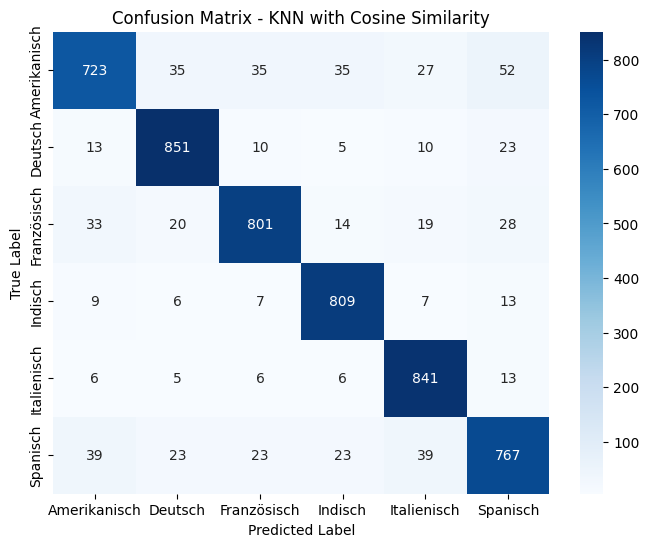

In [18]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_knn.classes_, yticklabels=best_knn.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - KNN with Cosine Similarity')
plt.show()
